In [ ]:
pip install -U imbalanced-learn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
# For SMOTE
from imblearn.over_sampling import SMOTE
# For a more balanced evaluation, especially with class_weight or SMOTE
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Support vector machine
the cohort is imbalanced, therefore using two approaches to get better result

## Approach 1
Using class_weight='balanced' in your SVC

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score

# Load your data
features_prep_df = pd.read_csv('/content/drive/MyDrive/medical-data/data/preped/features_multivariate.csv')

# Drop the 'stay_id' column if it exists and is not needed
if 'stay_id' in features_prep_df.columns:
    features_prep_df = features_prep_df.drop('stay_id', axis=1)

# Assuming 'outcome' is the target variable
X = features_prep_df.drop('outcome', axis=1)
y = features_prep_df['outcome'] # Make sure your 'failed' and 'success' are encoded (e.g., 0 and 1)

# Stratify the split to ensure similar class proportions in train and test sets
# This is especially important for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Support Vector Machine classifier with class_weight
print("\nTraining SVC with class_weight='balanced'...")
svm_classifier_balanced = SVC(kernel='linear', class_weight='balanced', probability=True) # probability=True for roc_auc_score with predict_proba
svm_classifier_balanced.fit(X_train, y_train)



Training SVC with class_weight='balanced'...


SVC(class_weight='balanced', kernel='linear', probability=True)

In [ ]:
# Make predictions on the test set
# y_pred_balanced = svm_classifier_balanced.predict(X_test)
y_pred_balanced = (svm_classifier_balanced.predict_proba(X_test)[:, 1] >= 0.85).astype(bool)

# Evaluate the model
print("\nEvaluation for SVC with class_weight='balanced':")
cm = confusion_matrix(y_test, y_pred_balanced)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_balanced)}")


Evaluation for SVC with class_weight='balanced':
Confusion Matrix:
[[ 139   44]
 [ 124 1807]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.76      0.62       183
         1.0       0.98      0.94      0.96      1931

    accuracy                           0.92      2114
   macro avg       0.75      0.85      0.79      2114
weighted avg       0.94      0.92      0.93      2114

Balanced Accuracy: 0.8476737045558093


In [ ]:
# f1 score
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred_balanced))

0.955579058699101


### Calculate Youden's Index

In [ ]:
# Assuming the standard scikit-learn confusion matrix layout:
# TN = cm[0, 0]
# FP = cm[0, 1]
# FN = cm[1, 0]
# TP = cm[1, 1]
# Make sure this mapping is correct for your specific positive/negative class encoding.
# If your positive class is 1 and negative class is 0:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

# Handle potential division by zero if a class has no samples in the test set or no predictions for it
if (TP + FN) == 0:
    sensitivity = 0.0
    print("Warning: Denominator for sensitivity (TP + FN) is zero.")
else:
    sensitivity = TP / (TP + FN)

if (TN + FP) == 0:
    specificity = 0.0
    print("Warning: Denominator for specificity (TN + FP) is zero.")
else:
    specificity = TN / (TN + FP)

youden_index = sensitivity + specificity - 1

print(f"Sensitivity (Recall for positive class): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Youden's Index: {youden_index}")

Sensitivity (Recall for positive class): 0.9357845675815639
Specificity: 0.7595628415300546
Youden's Index: 0.6953474091116185


### Calculate AUC-ROC

In [ ]:
# If your minority class is 'failed' (e.g., label 0) and majority 'success' (e.g., label 1),
# and you want AUC for detecting 'failed', you might need to adjust roc_auc_score if y_test has string labels.
# Ensure y_test and y_pred_proba are numeric.
try:
    y_pred_proba_balanced = svm_classifier_balanced.predict_proba(X_test)[:, 1] # Probability of the positive class
    # If your "failed" class is 0, you might want predict_proba(X_test)[:, 0]
    # Or, ensure your positive label in roc_auc_score matches the "failed" class if it's not 1.
    # For simplicity, assuming '1' is the class of interest or your labels are 0 and 1.
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_balanced)}")
except Exception as e:
    print(f"Could not calculate AUC-ROC with predict_proba: {e}")
    # Fallback to decision_function if predict_proba fails or is not desired
    try:
        y_score_balanced = svm_classifier_balanced.decision_function(X_test)
        print(f"AUC-ROC (using decision function): {roc_auc_score(y_test, y_score_balanced)}")
    except Exception as e_df:
        print(f"Could not calculate AUC-ROC with decision_function: {e_df}")

AUC-ROC: 0.8225897281342943


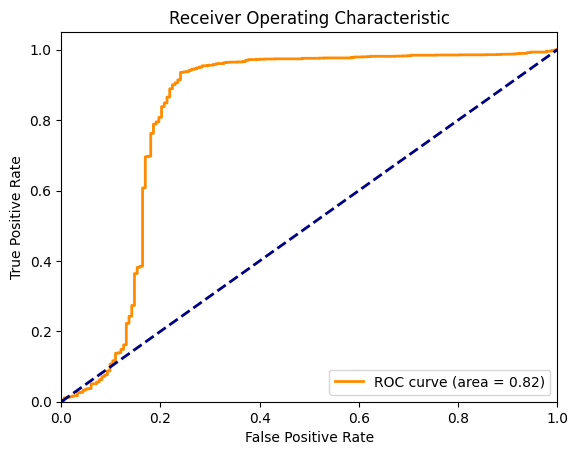

In [ ]:
# prompt: Plot ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_pred_proba_balanced is available from previous code
# If not, uncomment the following lines to compute the predicted probabilities
# y_pred_proba_balanced = svm_classifier_balanced.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_balanced)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# save model pt file
import pickle
with open('/content/drive/MyDrive/medical-data/data/model_multi/SVM/svm_classifier_balanced.pkl', 'wb') as file:
    pickle.dump(svm_classifier_balanced, file)

In [ ]:
# save y_test and y_pred_proba_balanced
import numpy as np
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/SVM/y_test_SVM.csv', y_test, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/SVM/y_pred_proba_SVM.csv', y_pred_proba_balanced, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/SVM/X_train_SVM.csv', X_train, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/SVM/X_test_SVM.csv', X_test, delimiter=',')

# NN

## Configuration & Data Loading

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Configuration & Data Loading ---
FILE_PATH = '/content/drive/MyDrive/medical-data/data/preped/features_multivariate.csv' # Make sure this path is correct
TARGET_VARIABLE = 'outcome' # The column name of your target variable
POSITIVE_CLASS_LABEL = 1 # Assuming 1 is the positive class (e.g., 'failed' or 'event occurred')
NEGATIVE_CLASS_LABEL = 0 # Assuming 0 is the negative class

# Load your data
try:
    features_prep_df = pd.read_csv(FILE_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file was not found at {FILE_PATH}")
    print("Please ensure the file path is correct and the data is accessible.")
    exit()

# Drop the 'stay_id' column if it exists and is not needed for modeling
if 'stay_id' in features_prep_df.columns:
    features_prep_df = features_prep_df.drop('stay_id', axis=1)
    print("Dropped 'stay_id' column.")

Data loaded successfully.


## Data Preparation

In [ ]:
# --- 2. Data Preparation ---
if TARGET_VARIABLE not in features_prep_df.columns:
    print(f"Error: Target variable '{TARGET_VARIABLE}' not found in the DataFrame columns: {features_prep_df.columns.tolist()}")
    exit()

X = features_prep_df.drop(TARGET_VARIABLE, axis=1)
y = features_prep_df[TARGET_VARIABLE]

# Ensure target variable is numerically encoded (e.g., 0 and 1)
# If your labels are 'failed' and 'success', you need to map them.
# For example: y = y.map({'failed': 1, 'success': 0})
# This example assumes y is already 0s and 1s.
if not pd.api.types.is_numeric_dtype(y):
    print(f"Warning: Target variable '{TARGET_VARIABLE}' is not numeric. Attempting to map common string labels.")
    # Example mapping, adjust if your labels are different
    unique_labels = y.unique()
    if len(unique_labels) == 2:
        # Try to infer positive/negative based on common terms if not already 0/1
        # This is a heuristic, ensure it matches your data's meaning
        label_map = {}
        if 'failed' in unique_labels and 'success' in unique_labels:
            label_map = {'failed': POSITIVE_CLASS_LABEL, 'success': NEGATIVE_CLASS_LABEL}
        elif 'yes' in unique_labels and 'no' in unique_labels:
            label_map = {'yes': POSITIVE_CLASS_LABEL, 'no': NEGATIVE_CLASS_LABEL}

        if label_map:
            print(f"Mapping labels: {label_map}")
            y = y.map(label_map)
            if y.isnull().any():
                print("Error: Null values found in target variable after mapping. Please check your labels.")
                exit()
        else:
            print("Error: Could not automatically map non-numeric target labels. Please encode them manually to 0 and 1.")
            exit()
    else:
        print("Error: Target variable must be binary (have exactly two unique classes) for this classifier.")
        exit()


# Stratify the split to ensure similar class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Feature Scaling: Neural networks are sensitive to feature scaling.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler.")

Training set shape: X_train: (8453, 13), y_train: (8453,)
Test set shape: X_test: (2114, 13), y_test: (2114,)
Features scaled using StandardScaler.


## Handle Class Imbalance

In [ ]:
# --- 3. Handle Class Imbalance (Calculate Class Weights) ---
# This helps the model pay more attention to the minority class.
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i : class_weights_values[i] for i in range(len(class_weights_values))}
print(f"Calculated class weights: {class_weights}")

Calculated class weights: {0: np.float64(5.766030013642565), 1: np.float64(0.5474740932642487)}


## Neural Network Model Definition

In [ ]:
# --- 4. Neural Network Model Definition ---
n_features = X_train_scaled.shape[1]

model = Sequential([
    # Input layer: n_features is the number of features in your data
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    # Dropout(0.3),
    # Dense(128, activation='relu', input_shape=(n_features,)),
    # Dropout(0.3),  # Dropout for regularization to prevent overfitting
    # Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    # Output layer: 1 neuron for binary classification, sigmoid activation for probability output
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy', # For binary classification
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # Add AUC as a metric
)

## Model Training

In [ ]:
# --- 5. Model Training ---
print("\nTraining the Neural Network...")
# Early stopping to prevent overfitting and stop training when performance plateaus
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=15,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity.
)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,          # Number of epochs (can be higher with early stopping)
    batch_size=64,       # Number of samples per gradient update
    validation_split=0.2, # Fraction of the training data to be used as validation data
    class_weight=class_weights, # Apply class weights
    callbacks=[early_stopping],
    verbose=1            # Set to 0 for less output, 1 for progress bar
)
print("Model training complete.")


Training the Neural Network...
Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7826 - auc: 0.5181 - loss: 0.6928 - val_accuracy: 0.7073 - val_auc: 0.5532 - val_loss: 0.6211
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6584 - auc: 0.5970 - loss: 0.6797 - val_accuracy: 0.6203 - val_auc: 0.6187 - val_loss: 0.6585
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - auc: 0.6331 - loss: 0.6610 - val_accuracy: 0.6115 - val_auc: 0.6543 - val_loss: 0.6655
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5874 - auc: 0.6157 - loss: 0.6834 - val_accuracy: 0.6038 - val_auc: 0.6733 - val_loss: 0.6645
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6109 - auc: 0.6569 - loss: 0.6633 - val_accuracy: 0.6115 - val_auc: 0.6835 - val_loss: 0.6583
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6209 - auc: 0.6865 - loss: 0.6400 - val_accuracy: 0.6286 - val_auc: 0.6898 - val_loss: 0.6443
Ep

In [ ]:
model.summary() # Print model architecture

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,021 (54.77 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,348 (36.52 KB)

## Model Evaluation

In [ ]:
# --- 6. Model Evaluation ---
print("\nEvaluating the model on the test set...")
loss, accuracy, auc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# Make predictions (probabilities)
y_pred_proba = model.predict(X_test_scaled).ravel() # .ravel() to make it a 1D array

# Convert probabilities to class labels (0 or 1) using a 0.5 threshold
y_pred_classes = (y_pred_proba > 0.5).astype(int)

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

# Classification Report
print("\nClassification Report:")
# Ensure target_names are correctly mapped if your y_test is 0/1
# For example, if 0 is 'success' and 1 is 'failed'
target_names = [f'Class {NEGATIVE_CLASS_LABEL} (e.g. Failed)', f'Class {POSITIVE_CLASS_LABEL} (e.g. Success)']
# If you have specific string names for your classes, use them:
# target_names = ['Success', 'Failed'] # Make sure order matches 0 and 1
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred_classes)
print(f"Balanced Accuracy: {bal_acc:.4f}")

# AUC-ROC (already calculated by model.evaluate if using tf.keras.metrics.AUC)
# Can also be calculated explicitly from probabilities
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC (from probabilities): {roc_auc:.4f}")


Evaluating the model on the test set...
Test Loss: 0.3613
Test Accuracy: 0.9210
Test AUC: 0.9262
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Confusion Matrix:
[[ 144   39]
 [ 128 1803]]

Classification Report:
                        precision    recall  f1-score   support

 Class 0 (e.g. Failed)       0.53      0.79      0.63       183
Class 1 (e.g. Success)       0.98      0.93      0.96      1931

              accuracy                           0.92      2114
             macro avg       0.75      0.86      0.79      2114
          weighted avg       0.94      0.92      0.93      2114

Balanced Accuracy: 0.8603
AUC-ROC (from probabilities): 0.9265


## Youden's Index

In [ ]:
# --- 7. Calculate Youden's Index ---
# TN = cm[0, 0] (True Negatives - Correctly predicted as NEGATIVE_CLASS_LABEL)
# FP = cm[0, 1] (False Positives - Incorrectly predicted as POSITIVE_CLASS_LABEL when actually NEGATIVE_CLASS_LABEL)
# FN = cm[1, 0] (False Negatives - Incorrectly predicted as NEGATIVE_CLASS_LABEL when actually POSITIVE_CLASS_LABEL)
# TP = cm[1, 1] (True Positives - Correctly predicted as POSITIVE_CLASS_LABEL)

# This assumes that the confusion matrix `cm` is structured such that:
# Row 0 / Column 0 corresponds to the NEGATIVE_CLASS_LABEL (e.g., 0)
# Row 1 / Column 1 corresponds to the POSITIVE_CLASS_LABEL (e.g., 1)
# This is the standard for scikit-learn's confusion_matrix if labels are [0, 1]

if cm.shape == (2,2): # Ensure it's a 2x2 matrix
    TN, FP, FN, TP = cm.ravel() if len(np.unique(y_test)) == 2 else (cm[0,0], cm[0,1], cm[1,0], cm[1,1])

    # Sensitivity (True Positive Rate or Recall for the positive class)
    if (TP + FN) == 0:
        sensitivity = 0.0
        print("Warning: Denominator for sensitivity (TP + FN) is zero.")
    else:
        sensitivity = TP / (TP + FN)

    # Specificity (True Negative Rate)
    if (TN + FP) == 0:
        specificity = 0.0
        print("Warning: Denominator for specificity (TN + FP) is zero.")
    else:
        specificity = TN / (TN + FP)

    youden_index = sensitivity + specificity - 1

    print(f"\nSensitivity (Recall for Class {POSITIVE_CLASS_LABEL}): {sensitivity:.4f}")
    print(f"Specificity (for Class {NEGATIVE_CLASS_LABEL}): {specificity:.4f}")
    print(f"Youden's Index: {youden_index:.4f}")
else:
    print("\nCould not calculate Youden's Index because the confusion matrix is not 2x2 (binary).")
    print("This might happen if your target variable had more than two classes after preprocessing.")


Sensitivity (Recall for Class 1): 0.9337
Specificity (for Class 0): 0.7869
Youden's Index: 0.7206


In [ ]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred_classes))

0.9557381394116088


## Plot training history

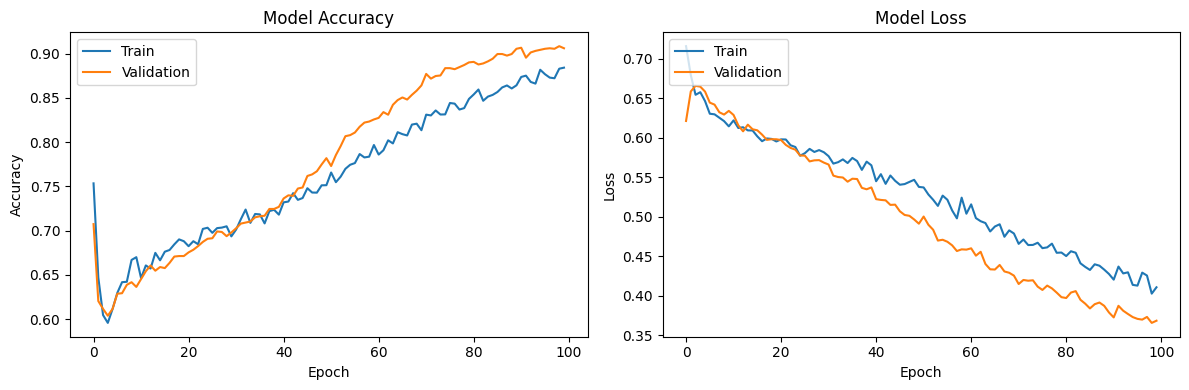

In [ ]:
# --- Optional: Plot training history (Accuracy and Loss) ---
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        print("Accuracy metrics not found in history.")

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        print("Loss metrics not found in history.")
    plt.tight_layout()
    plt.show()

# Check if running in an environment that supports plotting (like Colab)
try:
    plot_history(history)
except NameError: # If matplotlib is not imported or history object is not defined
    print("\nPlotting library (matplotlib) not available or history object missing. Skipping plots.")
except Exception as e:
    print(f"\nCould not generate plots: {e}")

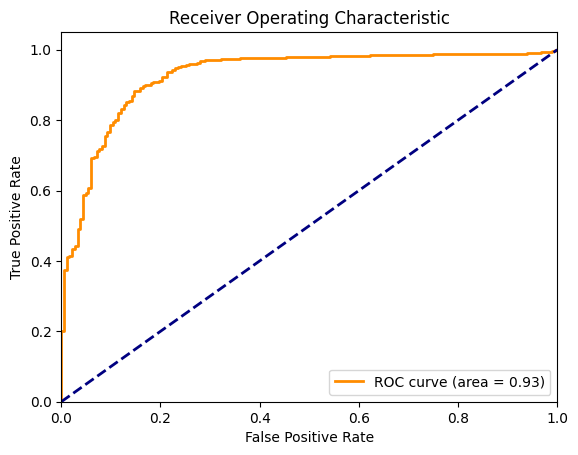

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_pred_proba_balanced is available from previous code
# If not, uncomment the following lines to compute the predicted probabilities
# y_pred_proba_balanced = svm_classifier_balanced.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# save model pt file
import pickle
import keras
with open('/content/drive/MyDrive/medical-data/data/model_multi/NN/NN_classifier_balanced.pkl', 'wb') as file:
    pickle.dump(model, file)
# save the model h5 file
model.save('/content/drive/MyDrive/medical-data/data/model_multi/NN/NN_classifier_balanced.keras')

In [ ]:
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/NN/y_test_NN.csv', y_test, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/NN/y_pred_proba_NN.csv', y_pred_proba, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/NN/X_train_NN.csv', X_train, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/NN/X_test_NN.csv', X_test, delimiter=',')

# KNN


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

## Configuration & Data Loading

In [ ]:
FILE_PATH = '/content/drive/MyDrive/medical-data/data/preped/features_multivariate.csv' # Make sure this path is correct
TARGET_VARIABLE = 'outcome' # The column name of your target variable
POSITIVE_CLASS_LABEL = 1 # Assuming 1 is the positive class (e.g., 'failed' or 'event occurred')
NEGATIVE_CLASS_LABEL = 0 # Assuming 0 is the negative class

# Load your data
try:
    features_prep_df = pd.read_csv(FILE_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file was not found at {FILE_PATH}")
    print("Please ensure the file path is correct and the data is accessible.")
    exit()

# Drop the 'stay_id' column if it exists and is not needed for modeling
if 'stay_id' in features_prep_df.columns:
    features_prep_df = features_prep_df.drop('stay_id', axis=1)
    print("Dropped 'stay_id' column.")

Data loaded successfully.


## Data Preparation

In [ ]:
if TARGET_VARIABLE not in features_prep_df.columns:
    print(f"Error: Target variable '{TARGET_VARIABLE}' not found in the DataFrame columns: {features_prep_df.columns.tolist()}")
    exit()

X = features_prep_df.drop(TARGET_VARIABLE, axis=1)
y = features_prep_df[TARGET_VARIABLE]

# Ensure target variable is numerically encoded (e.g., 0 and 1)
# This example assumes y is already 0s and 1s.
if not pd.api.types.is_numeric_dtype(y):
    print(f"Warning: Target variable '{TARGET_VARIABLE}' is not numeric. Attempting to map common string labels.")
    unique_labels = y.unique()
    if len(unique_labels) == 2:
        label_map = {}
        # Add more sophisticated mapping if necessary based on your actual labels
        if 'failed' in unique_labels and 'success' in unique_labels:
            label_map = {'failed': POSITIVE_CLASS_LABEL, 'success': NEGATIVE_CLASS_LABEL}
        elif 'yes' in unique_labels and 'no' in unique_labels:
            label_map = {'yes': POSITIVE_CLASS_LABEL, 'no': NEGATIVE_CLASS_LABEL}

        if label_map:
            print(f"Mapping labels: {label_map}")
            y = y.map(label_map)
            if y.isnull().any():
                print("Error: Null values found in target variable after mapping. Please check your labels.")
                exit()
        else:
            print("Error: Could not automatically map non-numeric target labels. Please encode them manually to 0 and 1.")
            exit()
    else:
        print("Error: Target variable must be binary (have exactly two unique classes) for this classifier.")
        exit()

# Stratify the split to ensure similar class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set shape: X_train: (8453, 13), y_train: (8453,)
Test set shape: X_test: (2114, 13), y_test: (2114,)


In [ ]:
# Feature Scaling: KNN is very sensitive to feature scaling.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler.")

Features scaled using StandardScaler.


## Finding an Optimal K

In [ ]:
# --- 3. Finding an Optimal K (Number of Neighbors) ---
# We can try a range of k values and see which one performs best on a validation set or using cross-validation.
# For simplicity, we'll iterate and check accuracy, but GridSearchCV is more robust.

param_grid = {'n_neighbors': np.arange(1, 31)} # Test K from 1 to 30
knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc') # 5-fold cross-validation, optimizing for AUC
print("\nSearching for optimal K using GridSearchCV...")
knn_gscv.fit(X_train_scaled, y_train)

best_k = knn_gscv.best_params_['n_neighbors']
print(f"Best K found: {best_k}")
print(f"Best AUC score during CV: {knn_gscv.best_score_:.4f}")


Searching for optimal K using GridSearchCV...
Best K found: 30
Best AUC score during CV: 0.8104


## KNN Model Training

In [ ]:
print(f"\nTraining KNN model with K={best_k}...")
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train_scaled, y_train)
print("Model training complete.")


Training KNN model with K=30...
Model training complete.


## Model Evaluation

In [ ]:
print("\nEvaluating the KNN model on the test set...")

# Make predictions
y_pred_classes = (knn_classifier.predict_proba(X_test_scaled)[:, POSITIVE_CLASS_LABEL] >= 0.91).astype(bool)
y_pred_proba = knn_classifier.predict_proba(X_test_scaled)[:, POSITIVE_CLASS_LABEL] # Probabilities for the positive class

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

# Classification Report
print("\nClassification Report:")
target_names = [f'Class {NEGATIVE_CLASS_LABEL} (e.g. Failed)', f'Class {POSITIVE_CLASS_LABEL} (e.g. Success)']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred_classes)
print(f"Balanced Accuracy: {bal_acc:.4f}")

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred_classes))


Evaluating the KNN model on the test set...

Confusion Matrix:
[[ 130   53]
 [ 363 1568]]

Classification Report:
                        precision    recall  f1-score   support

 Class 0 (e.g. Failed)       0.26      0.71      0.38       183
Class 1 (e.g. Success)       0.97      0.81      0.88      1931

              accuracy                           0.80      2114
             macro avg       0.62      0.76      0.63      2114
          weighted avg       0.91      0.80      0.84      2114

Balanced Accuracy: 0.7612
AUC-ROC: 0.8304
0.8828828828828829


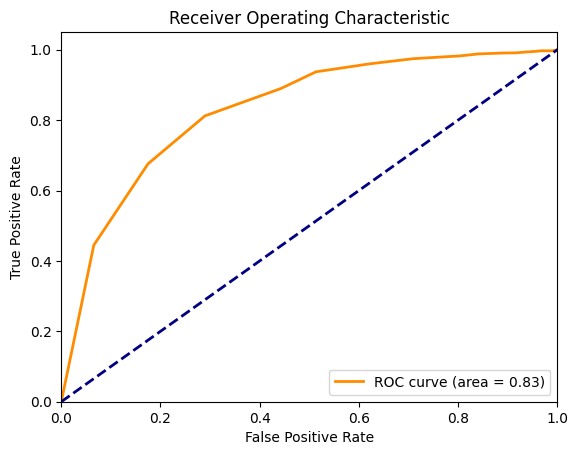

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_pred_proba_balanced is available from previous code
# If not, uncomment the following lines to compute the predicted probabilities
# y_pred_proba_balanced = svm_classifier_balanced.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Youden's Index

In [ ]:
if cm.shape == (2,2): # Ensure it's a 2x2 matrix
    # Standard scikit-learn confusion matrix structure:
    # TN = cm[0, 0] (Predicted Negative, Actual Negative)
    # FP = cm[0, 1] (Predicted Positive, Actual Negative)
    # FN = cm[1, 0] (Predicted Negative, Actual Positive)
    # TP = cm[1, 1] (Predicted Positive, Actual Positive)
    # This assumes NEGATIVE_CLASS_LABEL (e.g., 0) is the first row/col,
    # and POSITIVE_CLASS_LABEL (e.g., 1) is the second row/col.
    TN, FP, FN, TP = cm.ravel()

    # Sensitivity (True Positive Rate or Recall for the POSITIVE_CLASS_LABEL)
    if (TP + FN) == 0:
        sensitivity = 0.0
        print("Warning: Denominator for sensitivity (TP + FN) is zero.")
    else:
        sensitivity = TP / (TP + FN)

    # Specificity (True Negative Rate for the NEGATIVE_CLASS_LABEL)
    if (TN + FP) == 0:
        specificity = 0.0
        print("Warning: Denominator for specificity (TN + FP) is zero.")
    else:
        specificity = TN / (TN + FP)

    youden_index = sensitivity + specificity - 1

    print(f"\nSensitivity (Recall for Class {POSITIVE_CLASS_LABEL}): {sensitivity:.4f}")
    print(f"Specificity (for Class {NEGATIVE_CLASS_LABEL}): {specificity:.4f}")
    print(f"Youden's Index: {youden_index:.4f}")
else:
    print("\nCould not calculate Youden's Index because the confusion matrix is not 2x2 (binary).")


Sensitivity (Recall for Class 1): 0.8120
Specificity (for Class 0): 0.7104
Youden's Index: 0.5224


## Plot GridSearchCV

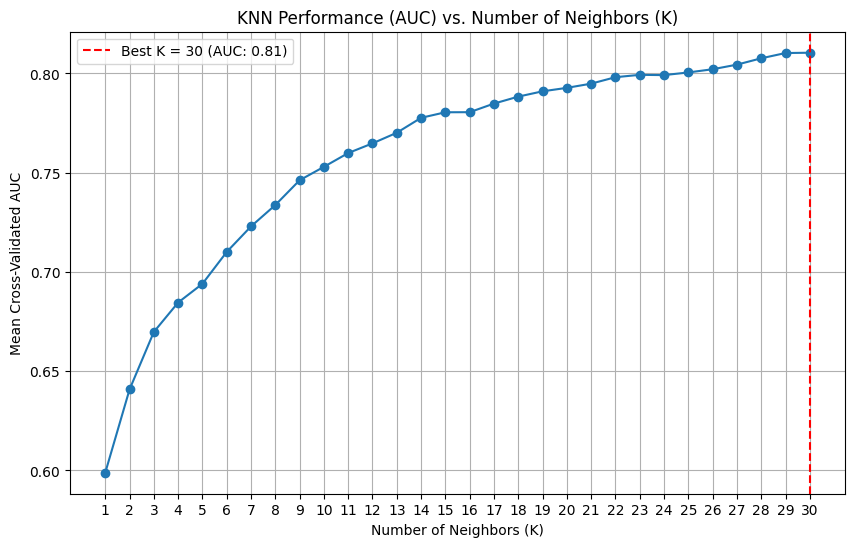

In [ ]:
# --- Optional: Plot GridSearchCV results (AUC vs. K) ---
try:
    plt.figure(figsize=(10, 6))
    plt.plot(param_grid['n_neighbors'], knn_gscv.cv_results_['mean_test_score'], marker='o', linestyle='-')
    plt.title('KNN Performance (AUC) vs. Number of Neighbors (K)')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Mean Cross-Validated AUC')
    plt.xticks(param_grid['n_neighbors'])
    plt.grid(True)
    plt.axvline(best_k, color='red', linestyle='--', label=f'Best K = {best_k} (AUC: {knn_gscv.best_score_:.2f})')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"\nCould not generate GridSearchCV plot: {e}")

In [ ]:
# save model pt file
import pickle
with open('/content/drive/MyDrive/medical-data/data/model_multi/KNN/KNN_classifier_balanced.pkl', 'wb') as file:
    pickle.dump(knn_classifier, file)

In [ ]:
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/KNN/y_test_KNN.csv', y_test, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/KNN/y_pred_proba_KNN.csv', y_pred_proba, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/KNN/X_train_KNN.csv', X_train, delimiter=',')
np.savetxt('/content/drive/MyDrive/medical-data/data/model_multi/KNN/X_test_KNN.csv', X_test, delimiter=',')